### notebook purpose

- compare joint recon of both echos to individual recon
    - currently, joint recon method is just concatenating echo1, echo2
    - preliminary results: helps significantly on echo2, negligible on echo1

In [45]:
import os, sys
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import normalize

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics, norm_imgs

In [78]:
def get_file_list(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()
    return files

# def compute_diff_map(im1, im2, c=4, norm='l1'):
# #     im1 = normalize(im1, axis=1, norm=norm)
# #     im2 = normalize(im2, axis=1, norm=norm)
#     diff = im1/im1.max() - im2/im2.max()
#     diff = diff - diff.min()
#     return c * diff # c*(im1-im2)

def plot_list(arr_list, title_list, clim=(0,1)):#None):
    
    SF = 2.56 # stretch factor
    NUM_COLS = len(arr_list)
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim, aspect=1./SF)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

In [58]:
id_list = ['005', '006', '030', '034', '048', '052', '065']#,
#            '080', '096', '099', '120', '144', '156', '158',
#            '176', '178', '188', '196', '198', '199', '218', '219', 
#            '221', '223', '224', '227', '235', '237', '240', '241',
#            '244', '248']

# deleted: '066', '173'

In [94]:
e_num_list = [1,2]
accel_list = [4,8]

NUM_SAMPS = len(id_list)
NUM_ECHOS = len(e_num_list)
NUM_VARS = 4
NUM_METRICS = 4

for accel in accel_list:

    path_q = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)
    path_ej = path_q + 'echo_joint/'

    metrics_sep = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    metrics_joint = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    im_list = np.empty((NUM_SAMPS, NUM_ECHOS, NUM_VARS, 512, 160))

    for idx, id_ in enumerate(id_list):

        for idx_e, e_num in enumerate(e_num_list):

            im_gt = np.load('{}echo{}/MTR_{}_gt.npy'.format(path_q, e_num, id_))
            im_gt_j = np.load('{}MTR_{}_e{}_gt.npy'.format(path_ej, id_, e_num))

            if abs(im_gt - im_gt_j).max() != 0:
                raise ValueError('ground-truths do not match for MTR_{}'.format(id_))
                continue

            im_dc = np.load('{}echo{}/MTR_{}_dc.npy'.format(path_q, e_num, id_))
            im_dc_j = np.load('{}MTR_{}_e{}-joint-recon_dc.npy'.format(path_ej, id_, e_num))
            
            # normalize to be on range of [0,1]
            im_gt, im_dc, im_dc_j = im_gt/im_gt.max(), im_dc/im_dc.max(), im_dc_j/im_dc_j.max()

            metrics_sep[idx_e][idx] = calc_metrics(im_gt, im_dc)
            metrics_joint[idx_e][idx] = calc_metrics(im_gt, im_dc_j)

            C = 4
            im_diff = C * (im_dc - im_dc_j)
            
            im_list[idx][idx_e] = np.array([im_gt, im_dc, im_dc_j, im_diff])

    perc_diff_list = (metrics_joint - metrics_sep) / metrics_sep

    vals_sep = np.mean(metrics_sep, axis=1)
    vals_joint = np.mean(metrics_joint, axis=1)
    perc_diff = np.mean(perc_diff_list, axis=1)
    
    print('accel {}x \n'.format(accel))
    print('recon sep')
    print(vals_sep, '\n')
    print('recon joint')
    print(vals_joint, '\n')
    print('perc diff')
    print(perc_diff)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

accel 4x 

recon sep
[[ 0.912  0.972  0.873 33.286]
 [ 0.756  0.925  0.746 32.2  ]] 

recon joint
[[ 0.912  0.971  0.87  33.104]
 [ 0.778  0.946  0.798 33.422]] 

perc diff
[[-0.    -0.001 -0.003 -0.005]
 [ 0.029  0.023  0.073  0.038]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accel 8x 

recon sep
[[ 0.849  0.958  0.815 30.547]
 [ 0.689  0.906  0.697 30.964]] 

recon joint
[[ 0.859  0.959  0.824 30.703]
 [ 0.694  0.927  0.746 31.89 ]] 

perc diff
[[0.012 0.001 0.012 0.005]
 [0.006 0.024 0.073 0.03 ]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



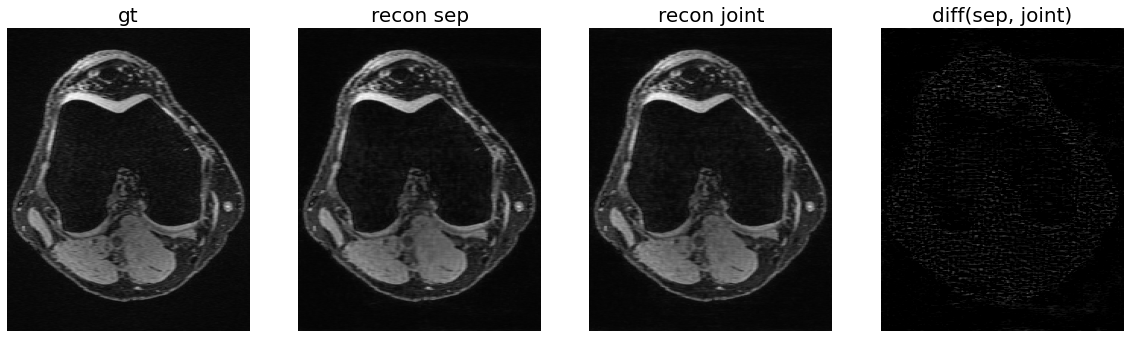

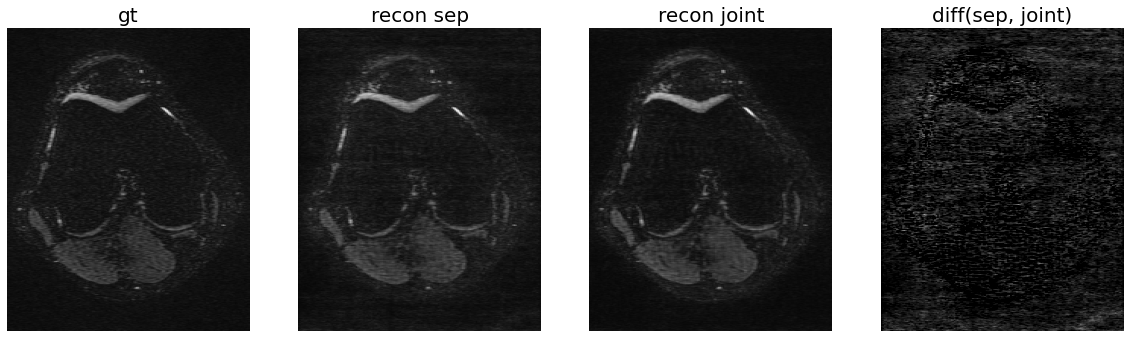

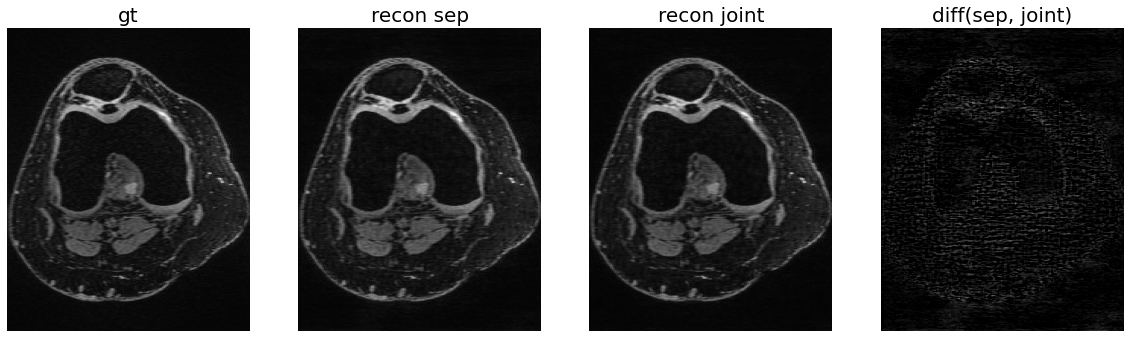

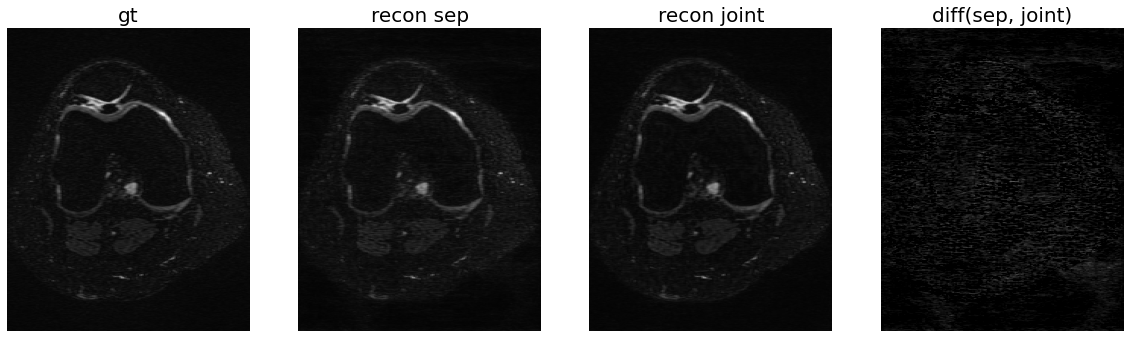

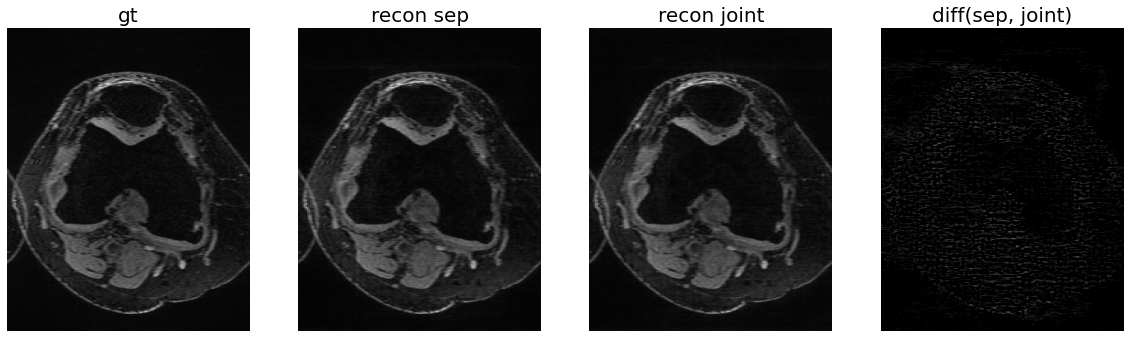

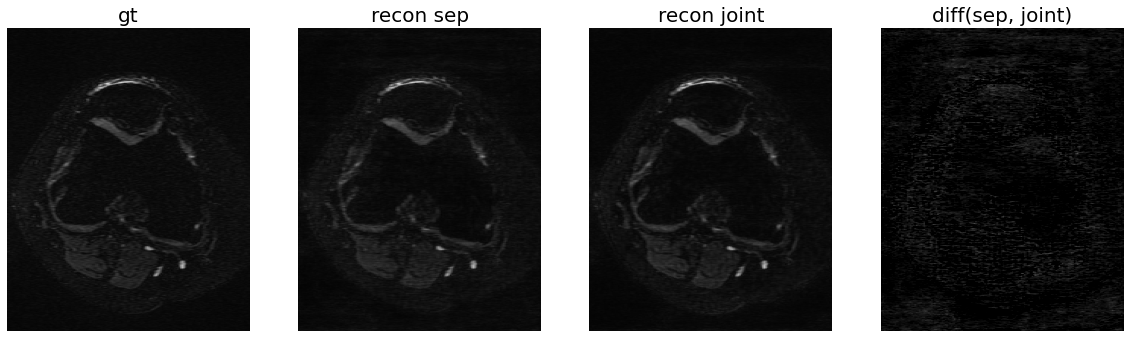

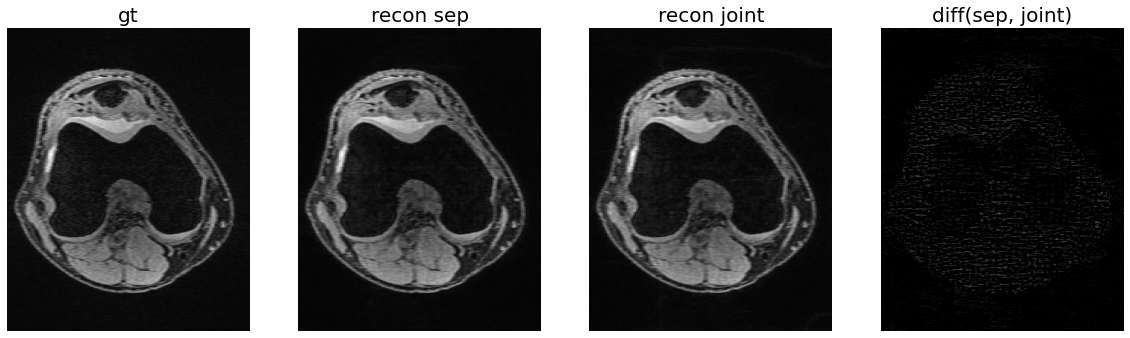

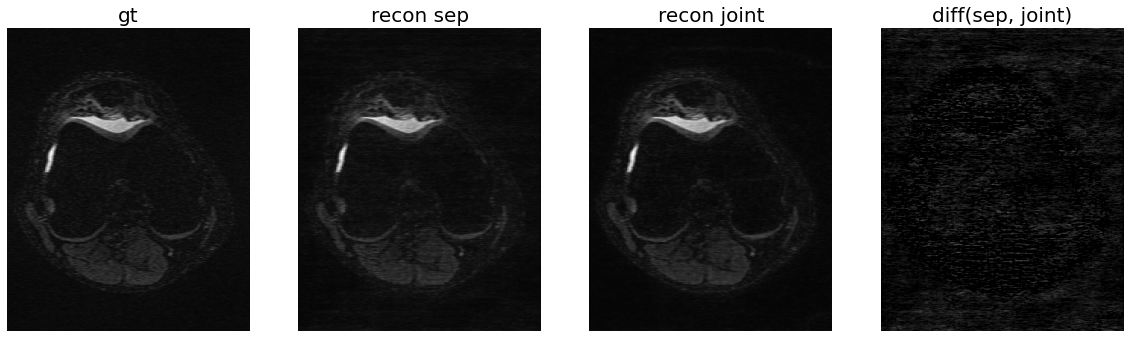

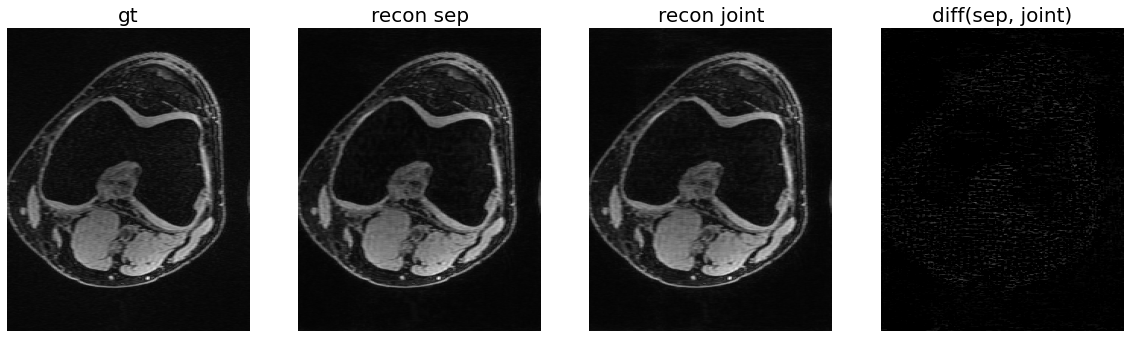

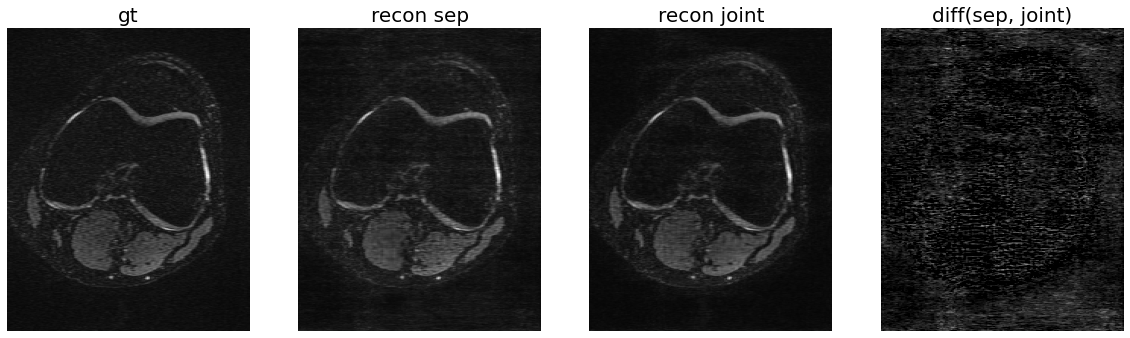

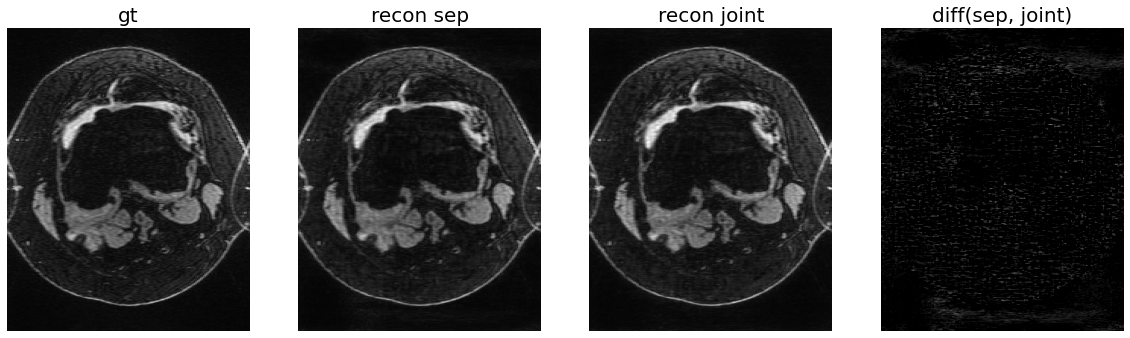

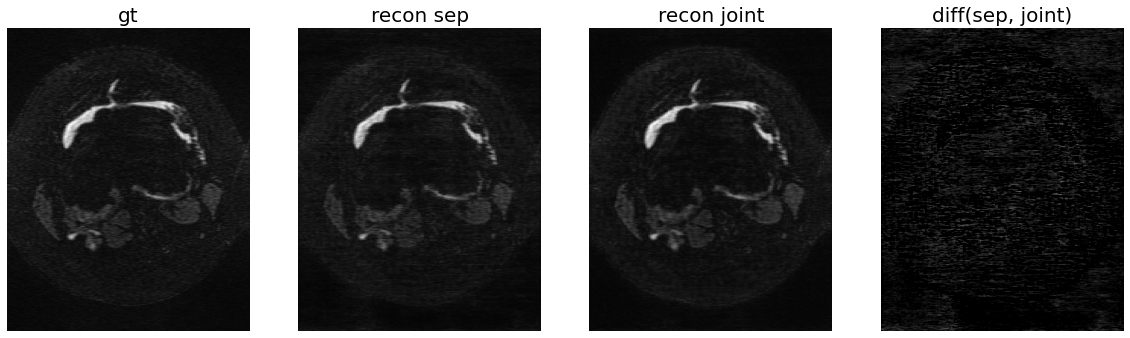

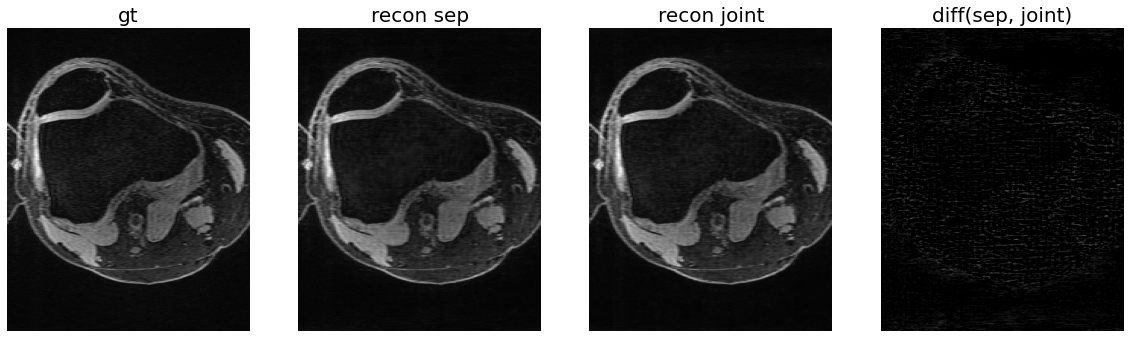

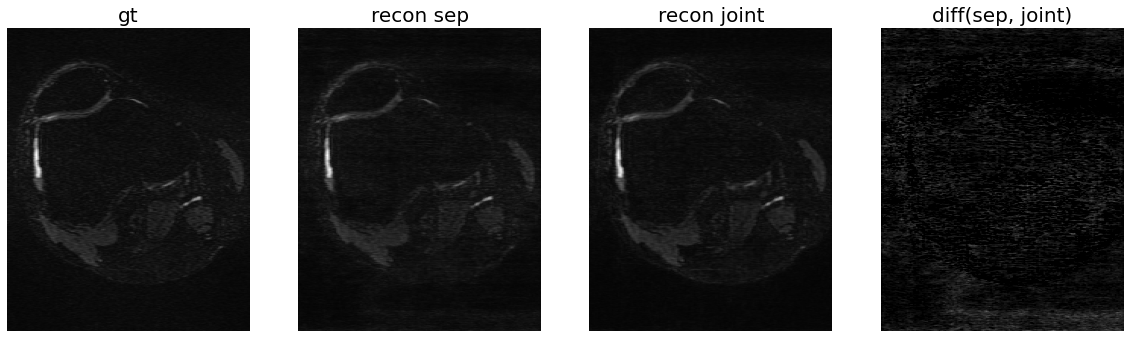

In [93]:
title_list = ['gt', 'recon sep', 'recon joint', 'diff(sep, joint)']

for idx_s, _ in enumerate(im_list):
    for e in im_list[idx_s]:
        plot_list(e, title_list)

num_params without stacked: 233280, with stacked: 235840

shape without: [(15, 7), (27, 12), (48, 20), (87, 33), (157, 56), (283, 95), torch.Size([512, 160])]

shape with: [(15, 7), (27, 12), (48, 20), (87, 33), (157, 56), (283, 95), torch.Size([512, 160])]